## Time Series Forecasting with Recurrent Neural Network(RNN)

In this project, I will build an end-to-end machine learning solution using a recurrent neural network(RNN) for electricity demand prediction problem via TensorFlow.

The dataset contains 2,075,259 measurements gathered in a house in France between Dec 2006 and Nov 2010. The aim is to predict the electricity demand of the next hour using past measurements. Since it is a regression problem, Mean Squared Error(MSE) and Mean Absolute Error(MAE) are used as evalution metrics. I will also try to share the reasoning behind my choices.


We will go through 5 steps:

1) **Preparing Libraries and Data:** Obtaining the training and test datasets<br>
2) **Preprocessing the Data:** Dealing with pixels and scaling the target<br>
3) **Building the Recurrent Neural Network for Regression:** Implementing TensorFlow RNN model<br>
4) **Model Results and Evaluation:** Making comments on the model results<br>
5) **Model Improvement with Date Information Addition:** Adding date information to improve the model results


### 1) Preparing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error, mean_absolute_error

2023-02-10 21:25:24.970431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Since it is a time series data, the train and test datasets are obtained by splitting the data without shuffling it. Missing values were dealt with interpolation. Instead of interpolation for missing values, forward fill can be used. Resample function was used as stated in the document.

In [2]:
# Reading the data
df = pd.read_csv('household_power_consumption.txt', sep=";", na_values="?", skipinitialspace=True)

# Obtaining Datetime column as index and resampling
df['Datetime'] = df.Date + " " + df.Time
df.drop(['Date', 'Time'], axis=1, inplace=True)
df['Datetime'] = pd.to_datetime(df.Datetime, format='%d/%m/%Y %H:%M:%S')
df.set_index('Datetime', inplace=True)

# Training and Test datasets
# Training dataset from 2006-12-16 to 2009-12-31
Xtrain_df = df.loc["2006-12-16 18:00:00":"2009-12-31 23:59:00",:].interpolate(method='linear').resample('1H', label='left', closed='left').sum()
ytrain_df = df['Global_active_power'].loc["2006-12-16 18:00:00":"2009-12-31 23:59:59"].interpolate(method='linear').resample('1H', label='left', closed='left').sum()
# Test dataset from 2010-01-01 to 2010-11-26
Xtest_df = df.loc["2010-01-01 00:00:00":"2010-11-26 20:59:00",:].interpolate(method='linear').resample('1H', label='left', closed='left').sum()
ytest_df = df['Global_active_power'].loc["2010-01-01 00:00:00":"2010-11-26 20:59:00"].interpolate(method='linear').resample('1H', label='left', closed='left').sum()
# instead of interpolation for missing values, forward fill can be used.

In [3]:
print('----------DATES----------')
print(f'Xtrain dates: {Xtrain_df.index[0]} to {Xtrain_df.index[-1]}')
print(f'ytrain dates: {ytrain_df.index[0]} to {ytrain_df.index[-1]}')
print(f'Xtest dates: {Xtest_df.index[0]} to {Xtest_df.index[-1]}')
print(f'ytest dates: {ytest_df.index[0]} to {ytest_df.index[-1]}')
print('\n----------SHAPES----------')
print(f'Xtrain shape: {Xtrain_df.shape} and ytrain shape: {ytrain_df.shape}')
print(f'Xtest shape: {Xtest_df.shape} and ytest shape: {ytest_df.shape}')

----------DATES----------
Xtrain dates: 2006-12-16 18:00:00 to 2009-12-31 23:00:00
ytrain dates: 2006-12-16 18:00:00 to 2009-12-31 23:00:00
Xtest dates: 2010-01-01 00:00:00 to 2010-11-26 20:00:00
ytest dates: 2010-01-01 00:00:00 to 2010-11-26 20:00:00

----------SHAPES----------
Xtrain shape: (26670, 7) and ytrain shape: (26670,)
Xtest shape: (7917, 7) and ytest shape: (7917,)


In [4]:
# Describing the Training dataset
print(f'Data Shape: {Xtrain_df.shape}')
print('\n -----Data Info and Types of Features-----')
Xtrain_df.info()

print('\n -----Describing Numerical Features-----')
display(Xtrain_df.describe())

print('\n -----Missing Values-----')
display(Xtrain_df.isnull().sum())

print('\n -----Data Frame-----')
display(Xtrain_df.head())

Data Shape: (26670, 7)

 -----Data Info and Types of Features-----
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26670 entries, 2006-12-16 18:00:00 to 2009-12-31 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    26670 non-null  float64
 1   Global_reactive_power  26670 non-null  float64
 2   Voltage                26670 non-null  float64
 3   Global_intensity       26670 non-null  float64
 4   Sub_metering_1         26670 non-null  float64
 5   Sub_metering_2         26670 non-null  float64
 6   Sub_metering_3         26670 non-null  float64
dtypes: float64(7)
memory usage: 1.6 MB

 -----Describing Numerical Features-----


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,26670.000000,26670.000000,26670.000000,26670.000000,26670.000000,26670.000000,26670.000000
mean,65.912263,7.332759,14437.975636,279.761526,69.276847,80.957743,373.747694
std,55.605243,4.023462,185.151336,232.938228,217.336374,260.534729,437.588071
min,7.440000,1.262000,13550.070000,30.200000,0.000000,0.000000,0.000000
25%,19.812000,4.620000,14334.620000,87.800000,0.000000,0.000000,0.000000
50%,47.477000,6.314000,14448.370000,202.900000,0.000000,20.000000,96.000000
75%,95.655500,8.786000,14555.727500,401.400000,0.000000,37.000000,818.000000
max,393.632000,46.460000,15114.120000,1703.000000,2902.000000,2786.000000,1471.470054



 -----Missing Values-----


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


 -----Data Frame-----


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0
2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0,266.0


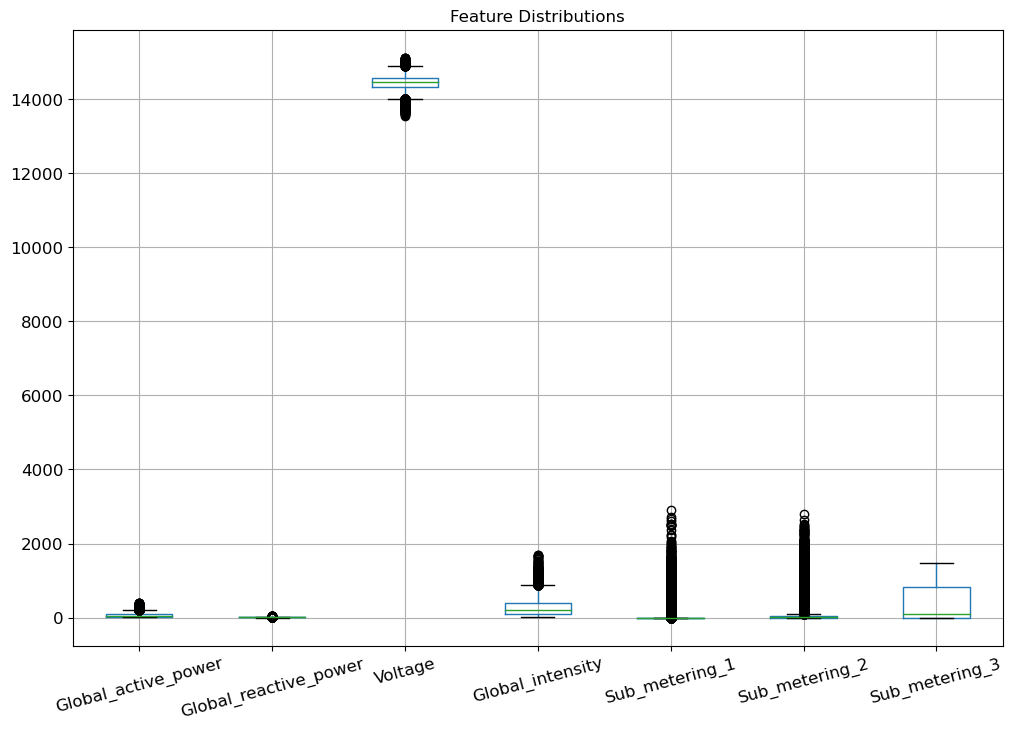

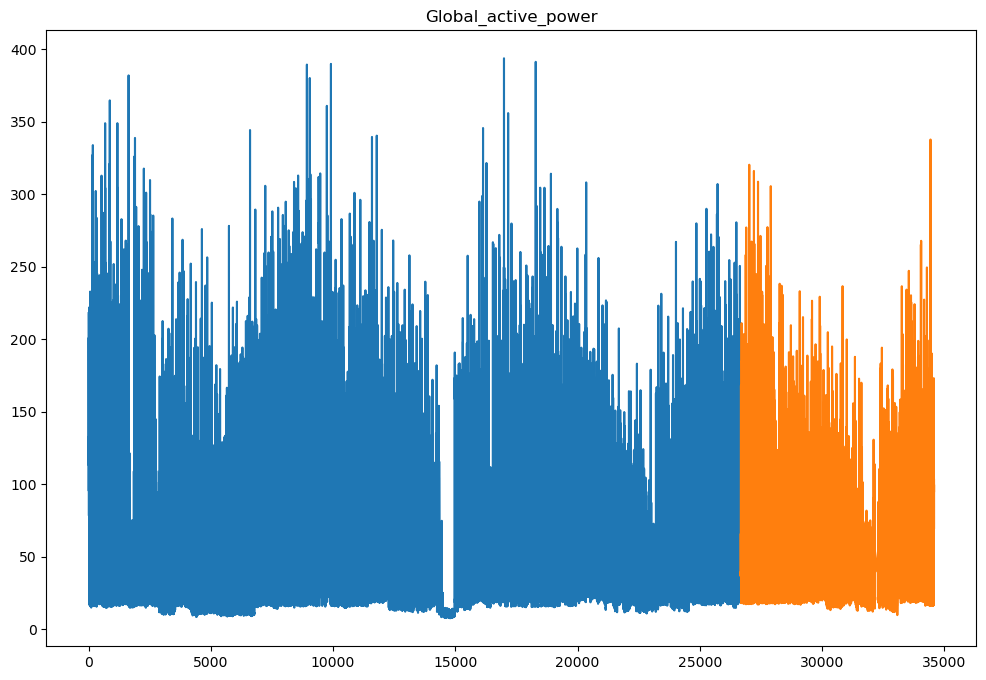

In [5]:
# Boxplots for each column to see the dsitributions
Xtrain_df.boxplot(figsize=(12,8), fontsize=12, rot=15)
plt.title('Feature Distributions')
plt.show()

# Plotting the target data
x1=np.arange(len(ytrain_df))
x2=np.arange(len(x1),len(ytrain_df)+len(ytest_df))
plt.figure(figsize=(12,8))
plt.plot(x1, ytrain_df)
plt.plot(x2, ytest_df)
plt.title('Global_active_power')
plt.show()

**Comment:** When we look at the boxplots, scaling is required before modelling. 


### 2) Preprocessing the Data

Min-max scaling with range of 0.05 and 0.95 was used for all features. We can not make Cross Validation since it is a time series data. We should generate similar data for our training data by using TimeseriesGenerator from Keras Library.

In [6]:
Xtrain = Xtrain_df.to_numpy()
ytrain = ytrain_df.to_numpy()
Xtest = Xtest_df.to_numpy()
ytest = ytest_df.to_numpy()

# Reshaping the targets
ytrain = ytrain[:,None]
ytest = ytest[:,None]

print(f'Xtrain: {Xtrain.shape}, ytrain: {ytrain.shape}\nXtest: {Xtest.shape}, ytest: {ytest.shape}')

Xtrain: (26670, 7), ytrain: (26670, 1)
Xtest: (7917, 7), ytest: (7917, 1)


In [7]:
# Scaling the datasets
scaler_y = MinMaxScaler(feature_range = (0.05, 0.95))
ytrain = scaler_y.fit_transform(ytrain)
ytest = scaler_y.transform(ytest)

scaler_X = MinMaxScaler(feature_range = (0.05, 0.95))
Xtrain = scaler_X.fit_transform(Xtrain)
Xtest = scaler_X.transform(Xtest)

In [8]:
window_size = 24 # 24 hours is chosen as window size. 
generator_train = TimeseriesGenerator(Xtrain,
                                      ytrain,
                                      length=window_size,
                                      batch_size=8)

generator_test = TimeseriesGenerator(Xtest,
                                      ytest,
                                      length=window_size,
                                      batch_size=1) # it is not important since generator_test will not be used in fit function

### 3) Building the Recurrent Neural Network for Regression

Unit activation was used at the output layer and the loss function was selected as mean squared error (MSE), since our problem is regression. To avoid overfitting, a dropout layer was added. For evaluation, Mean Absolute Error (MAE) was also used besides MSE.

In [9]:
# RNN architecture
rnn_model = keras.models.Sequential([
    keras.layers.LSTM(units = 128, # in other words, it is memory size. if you increase the number of monitoring time series, then you should increase the memory size due to complexity.   
                      input_shape = (window_size, Xtrain.shape[1])), # this time we have 30 x 7 dimension (window x # of features)
    keras.layers.Dense(units = 64, activation = "relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units = 16, activation = "relu"),
    keras.layers.Dense(units = 1) # No activation function since it is a regression problem
])

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 78,945
Trainable params: 78,945
Non-trainable params: 0
_________________________________________________________________


2023-02-10 21:30:01.496703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Compile part
rnn_model.compile(loss = "mean_squared_error", # since it is a regression problem
                  optimizer = "adam",
                  metrics = ['mae']) # Mean Absolute Error is also added as a metric.

# Fit part
rnn_history = rnn_model.fit(generator_train, 
                            steps_per_epoch = len(generator_train),
                            epochs = 5,
                            verbose = 1)


Epoch 1/5
3331/3331 [==============================] - 21s 6ms/step - loss: 0.0085 - mae: 0.0657
Epoch 2/5
3331/3331 [==============================] - 21s 6ms/step - loss: 0.0069 - mae: 0.0577
Epoch 3/5
3331/3331 [==============================] - 21s 6ms/step - loss: 0.0066 - mae: 0.0561
Epoch 4/5
3331/3331 [==============================] - 21s 6ms/step - loss: 0.0064 - mae: 0.0551
Epoch 5/5
3331/3331 [==============================] - 20s 6ms/step - loss: 0.0063 - mae: 0.0545


In [11]:
# Predict and Evaluation Part 
ytrain_hat = rnn_model.predict(generator_train)
ytest_hat = rnn_model.predict(generator_test)

y_train_hat_scaled = scaler_y.inverse_transform(ytrain_hat)[:,0]
y_test_hat_scaled = scaler_y.inverse_transform(ytest_hat)[:,0]
y_train_original = scaler_y.inverse_transform(ytrain)[:,0] 
y_test_original = scaler_y.inverse_transform(ytest)[:,0] 

print('--------Model Results--------')
print(f'Training RMSE: {round(np.sqrt(mean_squared_error(y_train_original[window_size:], y_train_hat_scaled)),2)}')
print(f'Test RMSE: {round(np.sqrt(mean_squared_error(y_test_original[window_size:], y_test_hat_scaled)),2)}')
print(f'Training MAE: {round(mean_absolute_error(y_train_original[window_size:], y_train_hat_scaled),2)}')
print(f'Test MAE: {round(mean_absolute_error(y_test_original[window_size:], y_test_hat_scaled),2)}')


7893/7893 [==============================] - 7s 825us/step
--------Model Results--------
Training RMSE: 32.93
Test RMSE: 29.69
Training MAE: 22.25
Test MAE: 20.23


### 4) Model Results and Evaluation

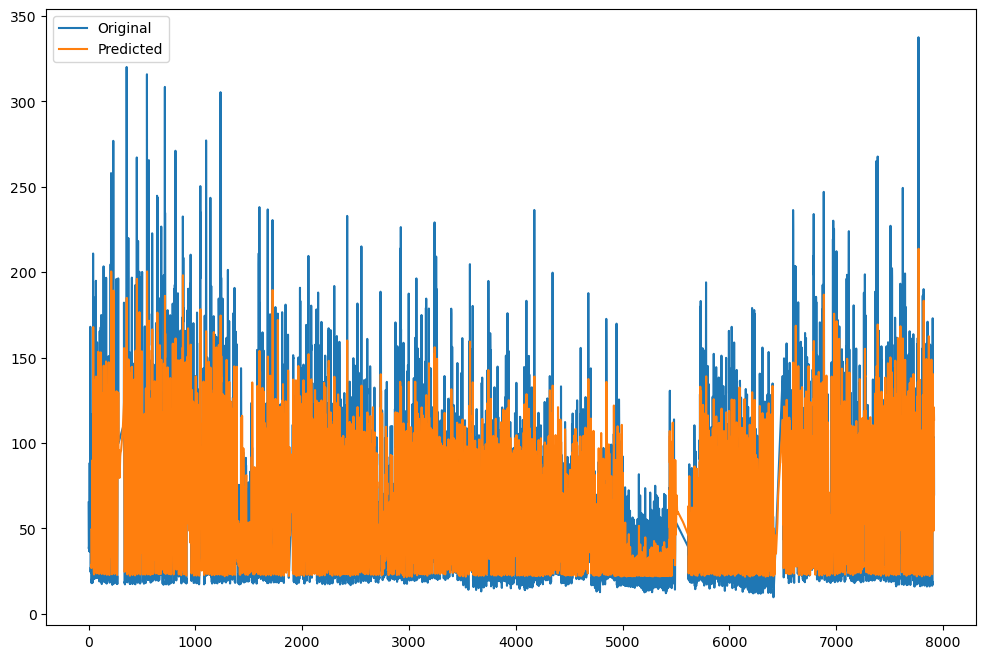

In [12]:
# Plotting the test results
plt.figure(figsize = (12,8))
plt.plot(np.arange(len(y_test_original)), y_test_original, label="Original")
plt.plot(np.arange(window_size, len(y_test_original)), y_test_hat_scaled, label="Predicted")
plt.legend()
plt.show()

#### Evaluation Comments

*   The RNN Model gave RMSE: 29.81 and MAE: 21.75 for test dataset. Adding month, day, and hour information to the model can improve the results by capturing the seasonal trends. These results can be considered as base results. In the next section, the date information will be added and some adjustements will be performed. 
*   Original and Predicted values were compared in the graph above. I think, RNN did a good job, but we will see the results after next section. 
*   To deal with overfitting, a dropout layer was used. 
*   Because of initialization, each run can support different results.

### 5) Model Improvement with Date Information Addition 

For the model improvement, month, day, and hour information were added to the model. Since the problem became more complex, some adjustments like increasing batch and memory sizes were made. Moreover, window size, number of epochs and dropout layers were increased for better results.

In [13]:
# Lets put month, day, and hour information to capture seasonal trends.
print(f'Xtrain: {Xtrain.shape}')
print(f'Xtest: {Xtest.shape}')

months = Xtrain_df.index.month.to_numpy().reshape(-1,1) / 12
days = Xtrain_df.index.day.to_numpy().reshape(-1,1) / 31
hours = (Xtrain_df.index.hour.to_numpy().reshape(-1,1) +1) / 24 # to get rid of zeros for time "00:00:00"

Xtrain2 = np.hstack((Xtrain, months, days, hours))
print(f'Xtrain shape with new info: {Xtrain2.shape}')

months_test = Xtest_df.index.month.to_numpy().reshape(-1,1) / 12
days_test = Xtest_df.index.day.to_numpy().reshape(-1,1) / 31
hours_test = (Xtest_df.index.hour.to_numpy().reshape(-1,1) +1) / 24 # to get rid of zeros for time "00:00:00"

Xtest2 = np.hstack((Xtest, months_test, days_test, hours_test))
print(f'Xtest shape with new info: {Xtest2.shape}')


Xtrain: (26670, 7)
Xtest: (7917, 7)
Xtrain shape with new info: (26670, 10)
Xtest shape with new info: (7917, 10)


In [14]:
window_size = 72 # After many trials, 72 hours is chosen as window size. 
generator_train2 = TimeseriesGenerator(Xtrain2,
                                      ytrain,
                                      length=window_size,
                                      batch_size=32) # batch size is increased to improve the model performance (speed)

generator_test2 = TimeseriesGenerator(Xtest2,
                                      ytest,
                                      length=window_size,
                                      batch_size=1) # it is not important since generator_test will not be used in fit function

In [15]:
# RNN architecture
rnn_model2 = keras.models.Sequential([
    keras.layers.LSTM(units = 256, # Since we have a more complex problem, memory size is increased accordingly.   
                      input_shape = (window_size, Xtrain2.shape[1])), # this time we have 30 x 10 dimension (window x # of features)
    keras.layers.Dropout(0.1), # additional dropout layers are added to deal with overfitting issue
    keras.layers.Dense(units = 64, activation = "relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units = 16, activation = "relu"),
    keras.layers.Dropout(0.1), # additional dropout layers are added to deal with overfitting issue
    keras.layers.Dense(units = 1)
])

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 78,945
Trainable params: 78,945
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Compile part
rnn_model2.compile(loss = "mean_squared_error", # since it is a regression problem
                  optimizer = "adam",
                  metrics = ['mae'])

# Fit part
rnn_history = rnn_model2.fit(generator_train2, 
                            steps_per_epoch = len(generator_train2),
                            epochs = 2, # Epochs is increased to get better results
                            verbose = 1)


Epoch 1/2
832/832 [==============================] - 70s 83ms/step - loss: 0.0113 - mae: 0.0770
Epoch 2/2
832/832 [==============================] - 70s 85ms/step - loss: 0.0079 - mae: 0.0627


In [17]:
# Predict and Evaluation Part 
ytrain_hat2 = rnn_model2.predict(generator_train2)
ytest_hat2 = rnn_model2.predict(generator_test2)

y_train_hat_scaled2 = scaler_y.inverse_transform(ytrain_hat2)[:,0]
y_test_hat_scaled2 = scaler_y.inverse_transform(ytest_hat2)[:,0]

print('--------Model Results--------')
print(f'Training RMSE: {round(np.sqrt(mean_squared_error(y_train_original[window_size:], y_train_hat_scaled2)),2)}')
print(f'Test RMSE: {round(np.sqrt(mean_squared_error(y_test_original[window_size:], y_test_hat_scaled2)),2)}')
print(f'Training MAE: {round(mean_absolute_error(y_train_original[window_size:], y_train_hat_scaled2),2)}')
print(f'Test MAE: {round(mean_absolute_error(y_test_original[window_size:], y_test_hat_scaled2),2)}')


7845/7845 [==============================] - 36s 5ms/step
--------Model Results--------
Training RMSE: 34.93
Test RMSE: 30.8
Training MAE: 24.2
Test MAE: 21.62


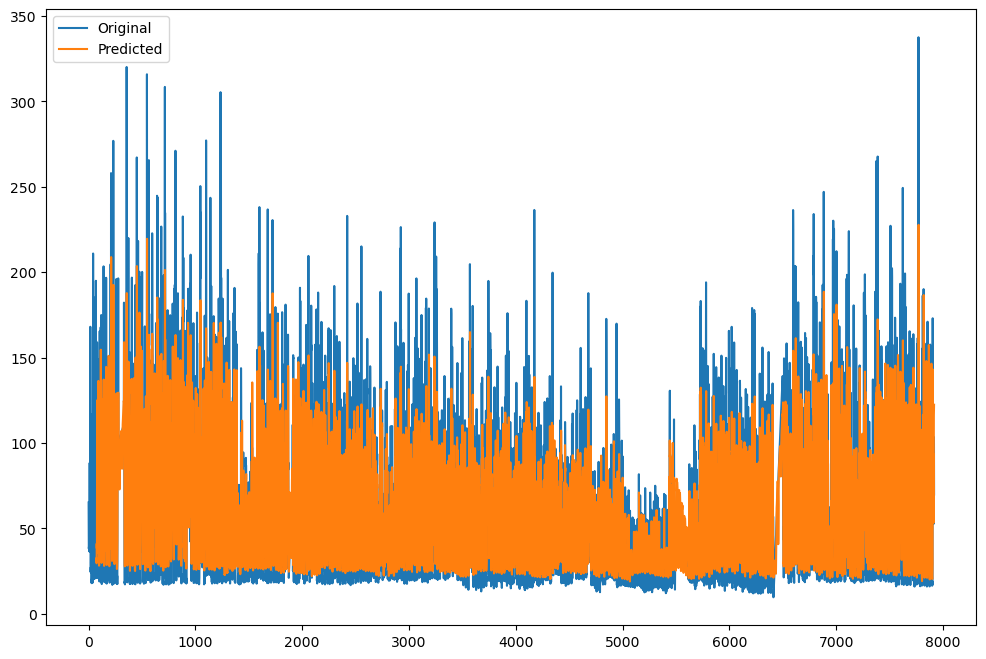

In [18]:
# Plotting the test results
plt.figure(figsize = (12,8))
plt.plot(np.arange(len(y_test_original)), y_test_original, label="Original")
plt.plot(np.arange(window_size, len(y_test_original)), y_test_hat_scaled2, label="Predicted")
plt.legend()
plt.show()

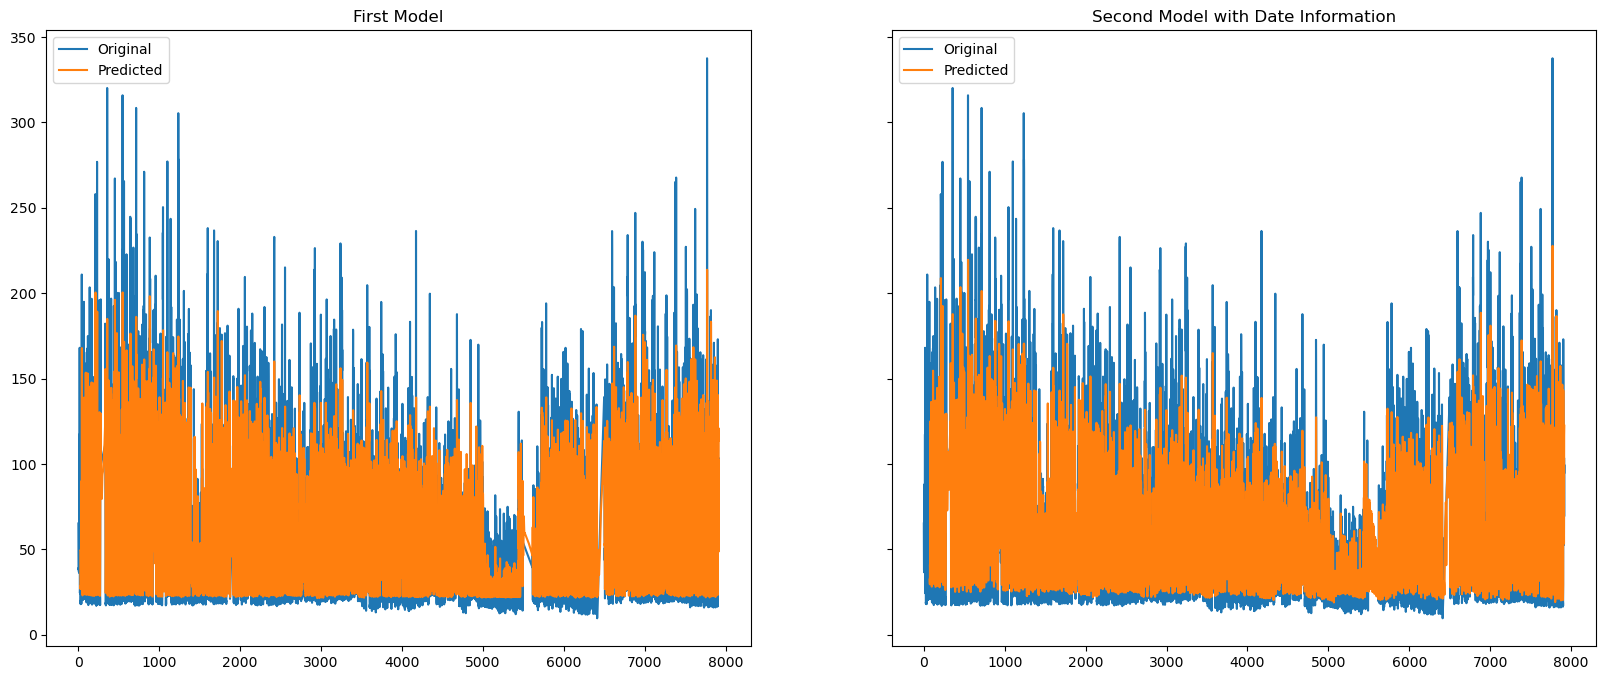

In [19]:
# Comparison of 2 RNN Model
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (20,8))
ax1.plot(np.arange(len(y_test_original)), y_test_original, label="Original")
ax1.plot(np.arange(24, len(y_test_original)), y_test_hat_scaled, label="Predicted")
ax1.set_title('First Model')
ax1.legend()
ax2.plot(np.arange(len(y_test_original)), y_test_original, label="Original")
ax2.plot(np.arange(window_size, len(y_test_original)), y_test_hat_scaled2, label="Predicted")
ax2.set_title('Second Model with Date Information')
ax2.legend()
plt.show()

#### Evaluation Comments

*   The second RNN model gave RMSE: 29.76 and MAE: 19.78 for test dataset while the first results were RMSE: 29.81 and MAE: 21.75. 
*   When we compare the graphs above, the second model has slightly better results. Especially in the interpolation area, the second model gave more realistic results. It also supported maximum value.